In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ntpath
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as kb
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as sklearn_train_test_split
import random
import os
from imgaug import augmenters as iaa
from google.colab.patches import cv2_imshow

In [ ]:
datadir = '/content/gdrive/MyDrive/nxp_data/'
coloums = ['Center_img', 'Speed', 'Steering']
data = pd.read_csv(os.path.join(datadir, '/content/gdrive/MyDrive/nxp_data/log1_empty_track.csv'), names = coloums)
data.head()

,Center_img,Speed,Steering
0,0.5.jpeg,0.3,0.3
1,1.0.jpeg,0.3,0.0
2,1.5.jpeg,0.3,0.3
3,2.0.jpeg,0.3,0.0
4,2.5.jpeg,0.3,0.3


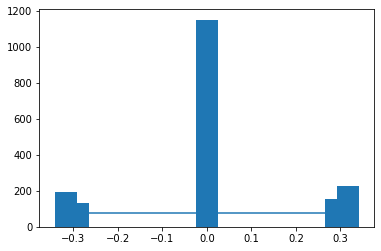

In [ ]:
num_bins = 25
samples_per_bin = 74
hist, bins = np.histogram(data['Steering'], num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print(data.iloc[2])

def load_center_speed_steering_val(datadir):
  center_path = []
  speed_val = []
  steering_val = []
  for i in range(len(data)):
    
    indexed_data= data.iloc[i]
    center, speed, steering = indexed_data[0] , indexed_data[1] , indexed_data[2]
    center_path.append(os.path.join(datadir, center.strip()))
    speed_val.append(float(indexed_data[1]))
    steering_val.append(float(indexed_data[2]))
    
  center_paths= np.asarray(center_path)
  speed_vals = np.asarray(speed_val)
  steering_vals = np.asarray(steering_val)
  return center_paths , speed_vals, steering_vals
  
center_paths, speed_vals, steering_vals = load_center_speed_steering_val(datadir + 'log1_empty_tack_images')

Center_img    1.5.jpeg
Speed              0.3
Steering           0.3
Name: 2, dtype: object


In [ ]:
def my_train_test_split(img_path, speed, steer):
  out = []
  for i in range(len(speed)):
    out.append([speed[i], steer[i]])

  return out

out = my_train_test_split(center_paths, speed_vals, steering_vals)

X_train , X_val , Y_train , Y_val = sklearn_train_test_split(center_paths , out , test_size = 0.2 , random_state = 1)

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(1485,)
(1485, 2)
(372,)
(372, 2)


**Data Augmentation**

In [ ]:
def zoom_in(image):
  zoom = iaa.Affine(scale = (1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed In Image')

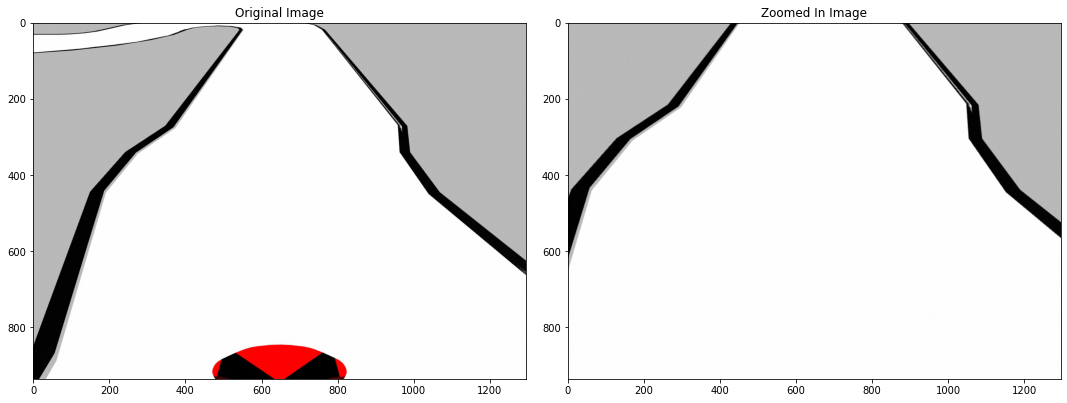

In [ ]:
image = center_paths[50]
original = mpimg.imread(image)
zoomed = zoom_in(original)

fig , axs = plt.subplots(1 , 2 , figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed)
axs[1].set_title('Zoomed In Image')

In [ ]:
def zoom_out(image):
  zoom = iaa.Affine(scale = (0.7,1))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed  Out Image')

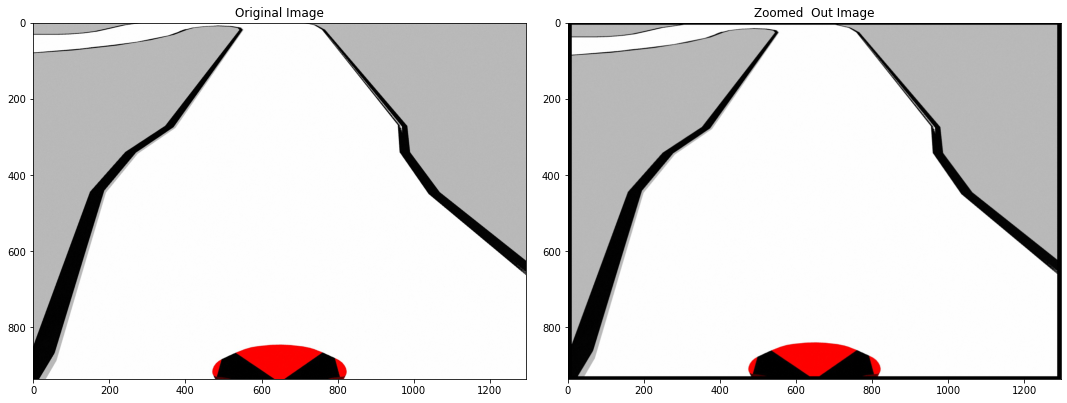

In [ ]:
image = center_paths[50]
original = mpimg.imread(image)
zoomed = zoom_out(original)

fig , axs = plt.subplots(1 , 2 , figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed)
axs[1].set_title('Zoomed  Out Image')

In [ ]:
def random_brightness(image):
  bright = iaa.Multiply((0.2 , 1.4))
  image = bright.augment_image(image)
  return image

Text(0.5, 1.0, 'Bright Image')

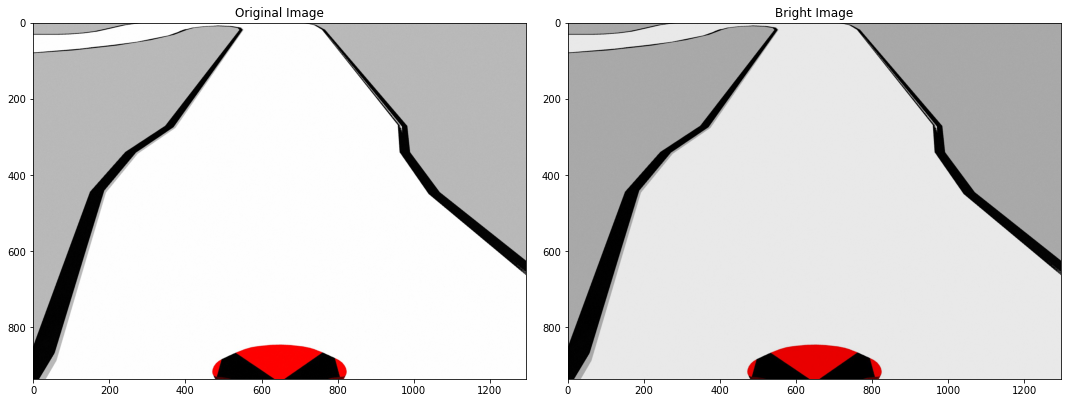

In [ ]:
image = center_paths[50]
original = mpimg.imread(image)
bright = random_brightness(original)

fig , axs = plt.subplots(1 , 2 , figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[0].set_title('Original Image')
axs[1].imshow(bright)
axs[1].set_title('Bright Image')

In [ ]:
def flip_image(image , out):
  image = cv2.flip(image, 1)
  steer = out[1]*(-1)
  return image , [out[0], steer]

[0.3, 0.0]
[0.3, -0.0]


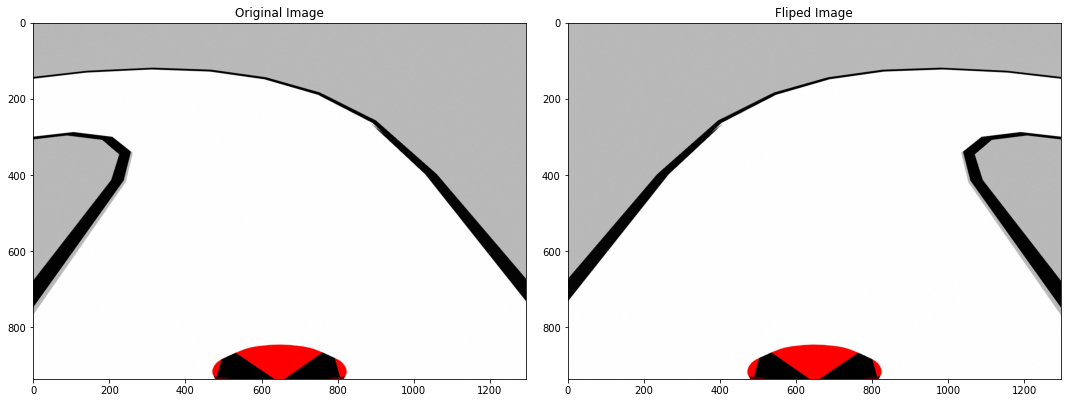

In [ ]:
img = center_paths[100]
original = mpimg.imread(img)
fliped , val = flip_image(original , out[100])

fig , axs = plt.subplots(1 , 2 , figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[0].set_title('Original Image')
print(out[100])
axs[1].imshow(fliped)
axs[1].set_title('Fliped Image')
print(val)

In [ ]:
def random_augment(image, val):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = zoom_in(image)
   
  if np.random.rand() < 0.5:
    image = zoom_out(image)
    
  if np.random.rand() < 0.5:
    image = random_brightness(image)
    
  if np.random.rand() < 0.5:
    image, val = flip_image(image, val)
    
  return image, val

[0.3, 0.0]
[0.33, -0.0]
[0.33, -0.33]
[0.33, 0.0]
[0.3, 0.3]
[0.3, -0.0]
[0.33, -0.33]
[0.33, 0.0]
[0.33, -0.0]
[0.33, 0.33]
[0.33, -0.0]
[0.3, 0.0]
[0.3, 0.3]
[0.33, -0.0]
[0.3, 0.0]


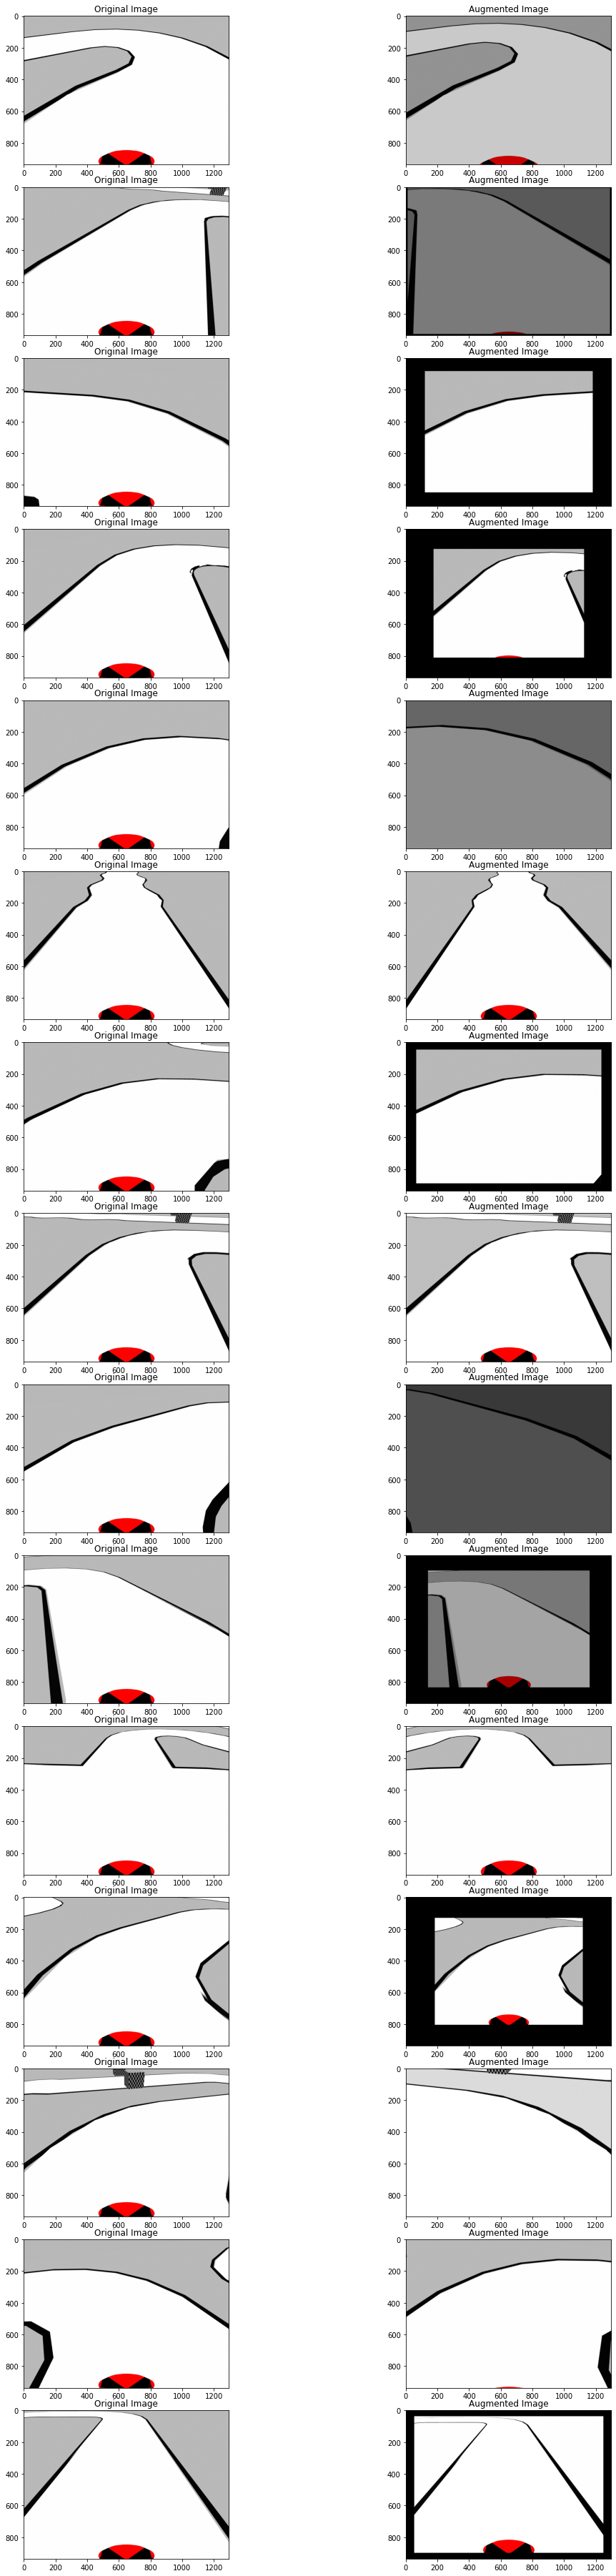

In [ ]:
nrows = 15
ncols = 2
fig , axs = plt.subplots(nrows , ncols , figsize = (15 , 50))
fig.tight_layout()

for i in range(nrows):
  random_index = random.randint(0 , len(center_paths)-1)
  
  image_path = center_paths[random_index]
  original = mpimg.imread(image_path)
  vals = out[random_index]
  augmented_img , outs = random_augment(image_path , vals)
  
  print(outs)
  axs[i][0].imshow(original)
  axs[i][0].set_title("Original Image")
  axs[i][1].imshow(augmented_img)
  axs[i][1].set_title("Augmented Image")

In [ ]:
def preprocess(img):
  img = img[150:800, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (256, 128))
  img = img/255
  return img

(128, 256, 3)


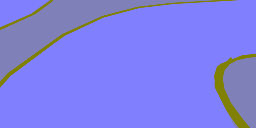

In [ ]:
img = cv2.imread('/content/gdrive/MyDrive/nxp_data/log1_empty_tack_images/105.5.jpeg')
img = preprocess(img)
print(img.shape)
cv2_imshow(img*255)

In [ ]:
def batch_generator(paths , vals , batch_size , check):
  
  while True:
    final_val = []
    image = []
    for i in range(batch_size):
    
      random_ind = random.randint(0 , len(paths)-1)
      speed_steer = vals[random_ind]
      out_val = [0.3, 0.0]
      out_val = np.asarray(out_val)
      
      if(check == 1):
        img , out_val = random_augment(paths[random_ind] , speed_steer)
      
      else:
        img = mpimg.imread(paths[random_ind])
      
      img = preprocess(img)
      image.append(img)
      final_val.append(out_val)

    yield (np.asarray(image) , np.asarray(final_val))      

Text(0.5, 1.0, 'Validation Image , Steering angle = [[0.3 0. ]]')

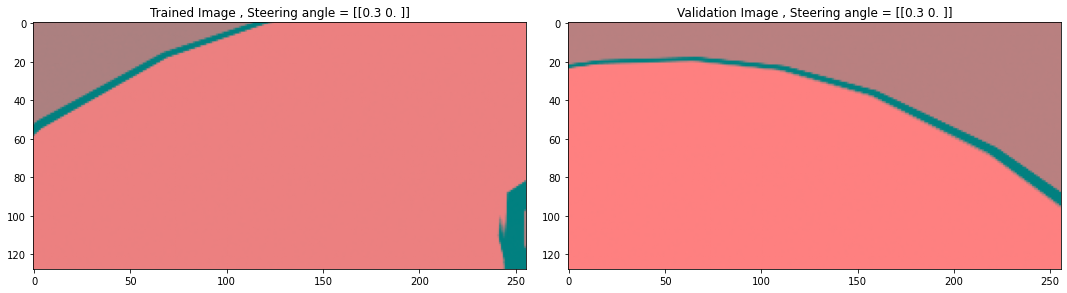

In [ ]:
X_train_gen , Y_train_gen = next(batch_generator(X_train , Y_train , 1 , 1))
X_val_gen , Y_val_gen = next(batch_generator(X_val , Y_val , 1 , 0))

fig , axs = plt.subplots(1 , 2 , figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[0].set_title('Trained Image , Steering angle = ' + str(Y_train_gen))
axs[1].imshow(X_val_gen[0] )
axs[1].set_title('Validation Image , Steering angle = ' + str(Y_val_gen))

In [ ]:
input = Input(shape=(128, 256, 3))
x = Conv2D(24, kernel_size=(3, 3), strides = 2, activation = 'elu')(input)
x = Conv2D(36, kernel_size=(3, 3), strides = 2, activation = 'elu')(x)
x = Conv2D(48, kernel_size=(3, 3), strides = 2, activation = 'elu')(x)
x = Conv2D(64, kernel_size=(3, 3), activation = 'elu')(x)
x = Conv2D(64, kernel_size=(3, 3), activation = 'elu')(x)

x = Flatten()(x)
x = Dense(100, activation = 'elu')(x)
x = Dense(50, activation = 'elu')(x)
x = Dense(10, activation = 'elu')(x)
output = Dense(2)(x)

model = tf.keras.Model(inputs=input, outputs=output)
model.summary()

model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(lr = 1e-3))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 63, 127, 24)       672       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 63, 36)        7812      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 31, 48)        15600     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 29, 64)        27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 27, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(batch_generator(X_train, Y_train, 50, 1),
                              steps_per_epoch = 50, 
                              epochs = 10, 
                              validation_data = batch_generator(X_val, Y_val, 50, 0), 
                              validation_steps = 25, 
                              verbose = 1, 
                              shuffle = True)

Epoch 1/10
16/50 [========>.....................] - ETA: 7:40 - loss: 10.7281

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [ ]:
model.save('model.h5')

In [ ]:
nxp_model = tf.keras.models.load_model('model.h5')
nxp_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 63, 127, 24)       672       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 63, 36)        7812      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 31, 48)        15600     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 29, 64)        27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 27, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 19008)             0     

(128, 256, 3)


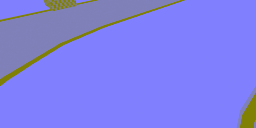

In [ ]:
img = cv2.imread('/content/gdrive/MyDrive/nxp_data/log1_empty_tack_images/300.0.jpeg')
img = preprocess(img)
print(img.shape)
cv2_imshow(img*255)

In [ ]:
img = np.expand_dims(img, axis=0)
pred = nxp_model.predict(img)
print(pred)

[[ 0.3787248  -0.05714482]]


In [ ]:
import tensorflow as tf
import cv2
import numpy as np

nxp_model = tf.keras.models.load_model('model.h5')

def preprocess(img):
  img = img[150:800, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (256, 128))
  img = img/255
  return img

def test(img):
  img = preprocess(img)
  img = np.expand_dims(img, axis=0)
  pred = nxp_model.predict(img)
  print(pred)
